# Exploratory Data Analysis

The code in this notebook was used for the exploratory data analysis part of the results/discussion section of the thesis.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from scipy.stats import anderson_ksamp
from umap import UMAP

plt.rcParams['font.size'] = 25
%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("data/parsed_data.csv")
df

,t,Steps,Event,idx,TFSI,TFSI-flip,EC,EC-flip,Li,Li-flip,...,EC-2-flip,Li-2,Li-2-flip,dx,dy,dz,dr,d,fast,system
0,459.0,306,1,1.0,0.0,78,4.0,50,0.0,0,...,147,0.0,0,-0.02,-1.10,-0.73,1.32,243.13,0.0,B2T1
1,459.0,306,1,2.0,2.0,122,3.0,80,0.0,106,...,164,1.0,110,1.05,-0.61,-0.49,1.31,250.02,0.0,B2T1
2,459.0,306,1,3.0,2.0,99,2.0,104,0.0,8,...,195,1.0,76,-0.27,0.40,0.92,1.04,251.00,0.0,B2T1
3,459.0,306,1,4.0,1.0,125,3.0,6,0.0,0,...,125,0.0,0,0.47,0.05,0.59,0.76,203.19,0.0,B2T1
4,459.0,306,1,5.0,0.0,0,4.0,38,0.0,0,...,162,0.0,16,1.51,1.04,-0.15,1.84,247.00,0.0,B2T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24895,8721.0,5814,19,96.0,2.0,41,2.0,18,0.0,3,...,60,0.0,50,0.98,-3.90,-1.55,4.31,344.49,1.0,B8T5
24896,8721.0,5814,19,97.0,3.0,164,1.0,9,0.0,0,...,127,1.0,39,-6.13,3.94,-1.87,7.52,347.39,1.0,B8T5
24897,8721.0,5814,19,98.0,2.0,16,2.0,6,0.0,0,...,31,0.0,0,-0.31,0.77,0.09,0.83,335.26,0.0,B8T5
24898,8721.0,5814,19,99.0,0.0,29,4.0,31,0.0,0,...,64,0.0,0,-1.63,1.24,-0.01,2.05,336.03,0.0,B8T5


In [3]:
columns = [
    "TFSI",
    "TFSI-flip",
    "EC",
    "EC-flip",
    "Li",
    "Li-flip",
    "TFSI-2",
    "TFSI-2-flip",
    "EC-2",
    "EC-2-flip",
    "Li-2",
    "Li-2-flip",
    "dr",
]

data = df[columns]

structure = ["EC", "EC-2", "Li", "Li-2", "TFSI", "TFSI-2"]
flips = ["EC-flip", "EC-2-flip", "Li-flip", "Li-2-flip", "TFSI-flip", "TFSI-2-flip"]

## Correlation Heatmap

The following code cell may need to be run twice for correct font scaling. This is a simple correlation matrix heatmap that plots that shows the pairwise Pearson correlation coefficients between all pairs of variables in the features + target (`"dr"`). The point of this is to see whether any of our features are correlated with the target.

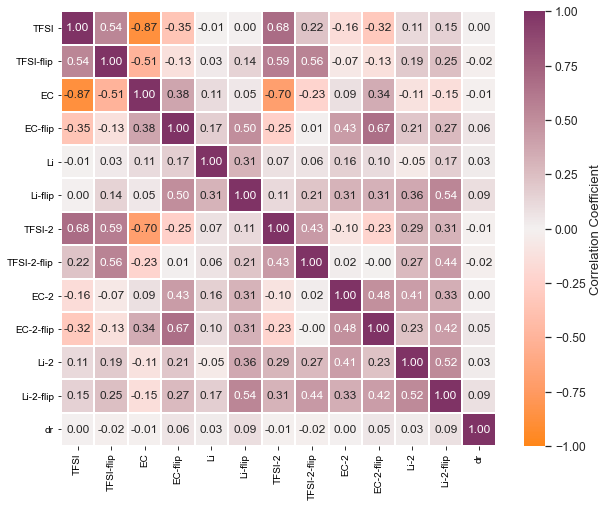

In [4]:
# create a custom diverging colormap going from purple to orange
colors = [
    "#7f3365",
    "#a2607d",
    "#c18e9c",
    "#dcbec2",
    "#f3f0f0",
    "#ffd1ca",
    "#ffb49b",
    "#ff9a63",
    "#ff8619",
]
custom_cmap = LinearSegmentedColormap.from_list(colors=colors, name="purple_to_orange")

fig, ax = plt.subplots(figsize=(10, 8))
sns.set(font_scale=1.1)
sns.heatmap(
    data.corr(),  # correlation matrix
    vmin=-1,
    vmax=1,
    annot=True,
    cmap=custom_cmap.reversed(),
    linewidths=2,
    cbar_kws={"label": "Correlation Coefficient"},
    ax=ax,
    fmt=".2f",  # format annotations to 2 decimals
    annot_kws={"size": 12},
    square=True,  # enforce square aspect ratio for heatmap
)
plt.savefig("figures/annot_correlation_matrix.png", dpi=400, bbox_inches="tight")
plt.show()

Unfortunately, the features have near-zero correlation with displacement across the board, but remember, these coefficients describe **linear** correlations! There may be some complex, nonlinear relationships between the features and the target.

To see whether our features are "good quality," there should be differences between them across simulation systems as there were for `dr`. That is, a slow system should have different values for the 12 features than a fast system (as is obviously the case for the target).

## Distribution of Target Across Systems

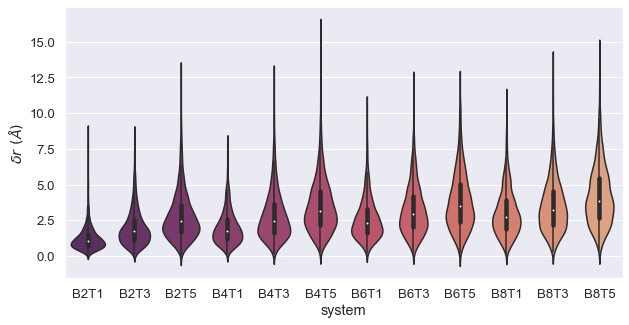

In [5]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(10, 5))
sns.violinplot(
    data=df, x="system", y="dr", palette="flare_r", scale="count",
)
plt.ylabel(r"$\delta r\ (\AA)$")
plt.savefig("figures/dr_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

Indeed, there are clear differences between the distributions of displacement across the 12 systems.

## Distributions of Coordination Number Across Systems

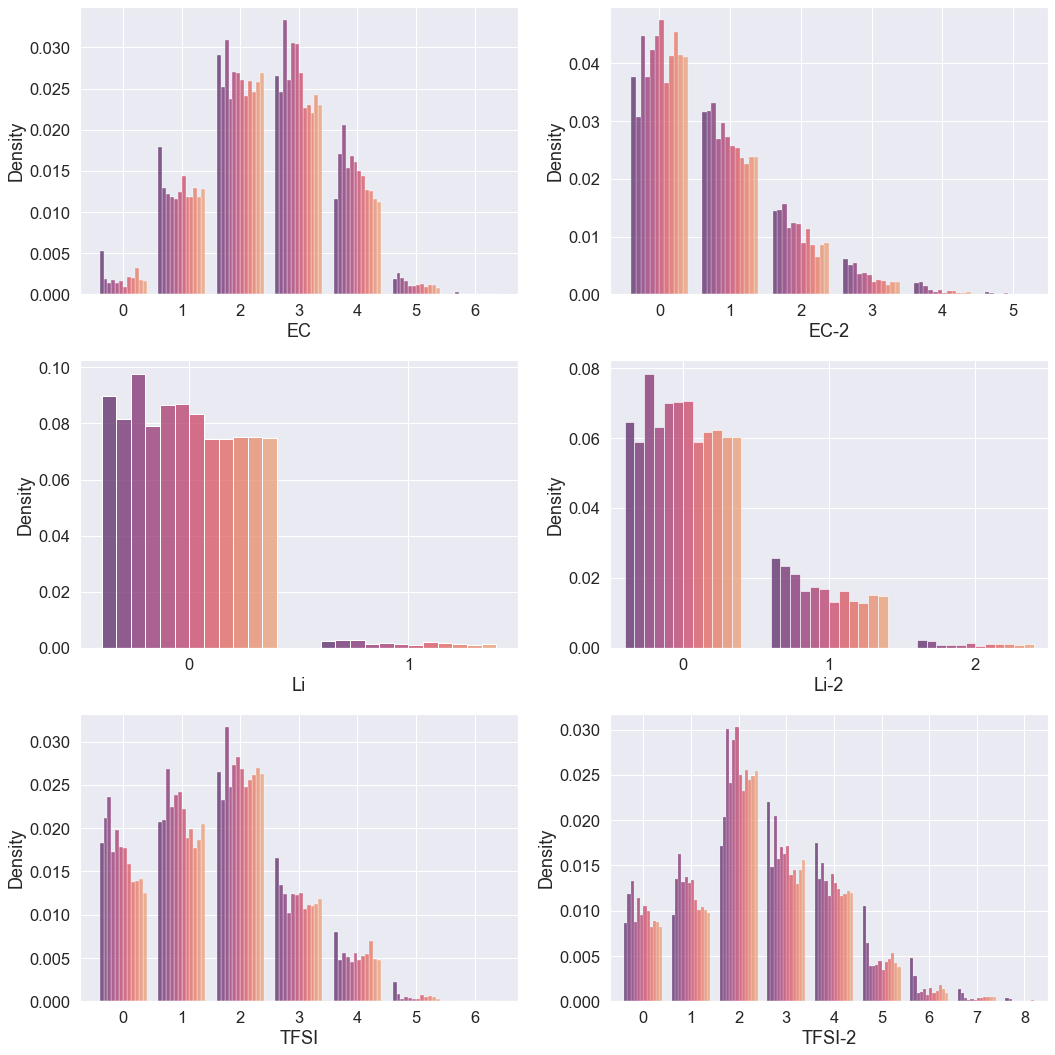

In [6]:
from matplotlib.ticker import FuncFormatter

sns.set(font_scale=1.5)
fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(structure, 1):
    plt.subplot(3, 2, i)
    ax = sns.histplot(
        data=df,
        x=col,
        hue="system",
        multiple="dodge",
        discrete=True,
        binwidth=1,
        bins=4,
        palette="flare_r",
        shrink=0.8,
        common_norm=True,
        stat="density",
        legend=True,
    )
    if col == "EC-2":
        plt.xlim(-0.7, 5.5)
    if col == "Li":
        plt.xlim(-0.5, 1.5)
        plt.xticks([0, 1])
    if col == "Li-2":
        plt.xlim(-0.5, 2.5)
        plt.xticks([0, 1, 2])
    if col == "TFSI-2":
        plt.xlim(-0.7, 8.5)
        plt.xticks(list(range(0, 9)))
    ax.get_legend().remove()  # remove legend from each
    plt.gca().xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: int(x))
    )  # int axis labels

fig.tight_layout()
plt.savefig("figures/coord_hist.png", dpi=400, bbox_inches="tight")
plt.show()

Very little difference between coordination numbers across systems, particularly for the Li<sup>+</sup> - Li<sup>+</sup> interaction.

## Distributions of Changes in Coordination Number Across Systems

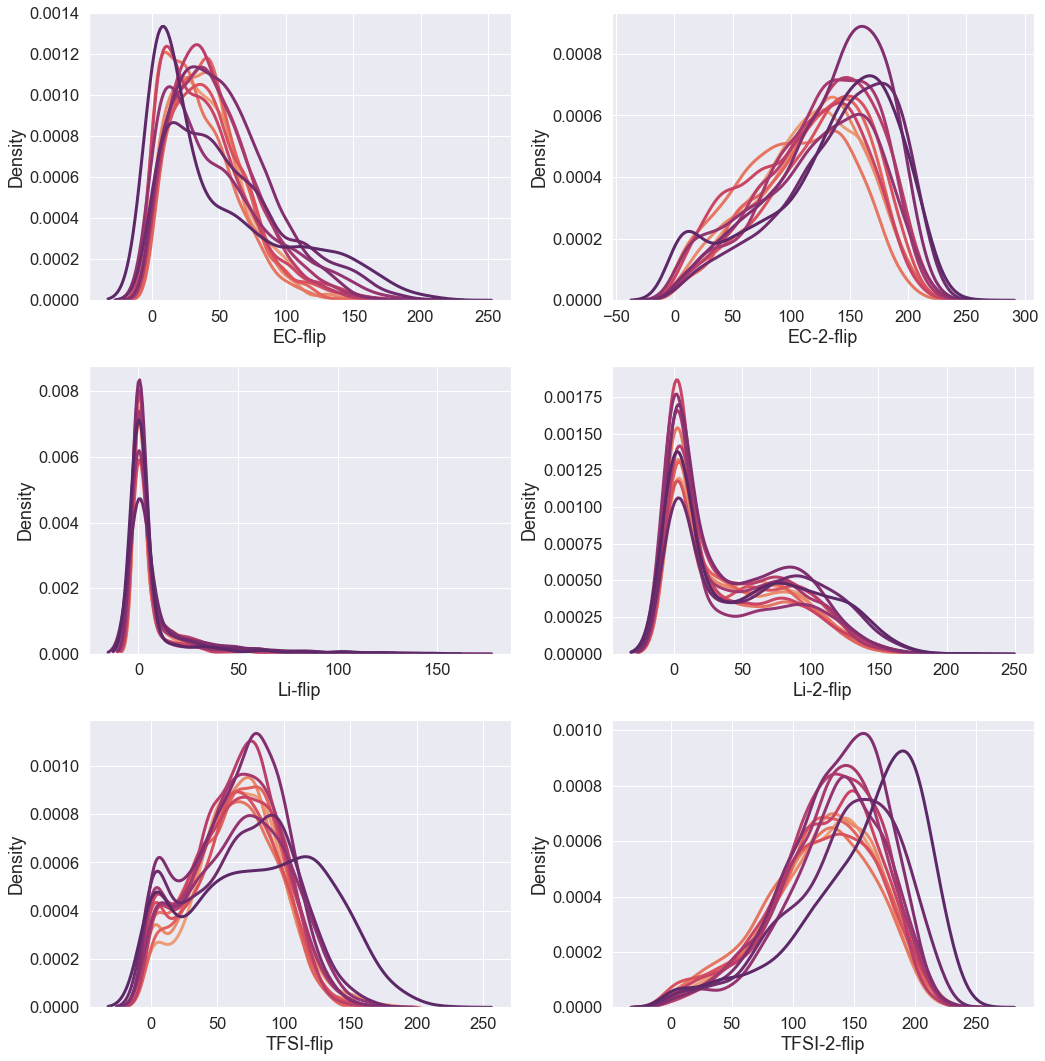

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
sns.set(font_scale=1.5)
for i, ax in zip(flips, axes.flat):
    sns.kdeplot(
        data=df,
        x=i,
        hue="system",
        palette="flare_r",
        linewidth=3,
        common_norm=True,
        alpha=0.8,
        ax=ax,
    )
    ax.get_legend().remove()
fig.tight_layout()
plt.savefig("figures/flips_kde.png", dpi=400, bbox_inches="tight")
plt.show()

A little better than before, but this is all rather subjective. Why not quantify the degree of similarity/dissimilarity? 

## Quantifying Dissimilarity of Distributions

Below, pairwise Anderson-Darling tests are performed between pairs of simulation systems for a given feature (and target, `"dr"`). The heatmaps will show purple wherever the pairwise tests determine that the distributions for that feature do *not* have a statistically significant difference, while any combinations that aren't distinct will lead to a light orange / peach square in the heatmap. 

There are $12 \choose 2 $ $= 66$ tests shown on the heatmap (the main diagonal of the heatmap will also be shown, all purple, just to make the visual look nice, but these aren't a part of the 66 pairwise combinations).  A higher number of distinct combinations means a feature has more pronounced differences between distributions across the 12 systems.

TFSI


C:\Users\khanm\AppData\Local\Temp/ipykernel_26172/311491798.py:12: UserWarning: p-value capped: true value larger than 0.25
  test = anderson_ksamp(
C:\Users\khanm\AppData\Local\Temp/ipykernel_26172/311491798.py:12: UserWarning: p-value floored: true value smaller than 0.001
  test = anderson_ksamp(


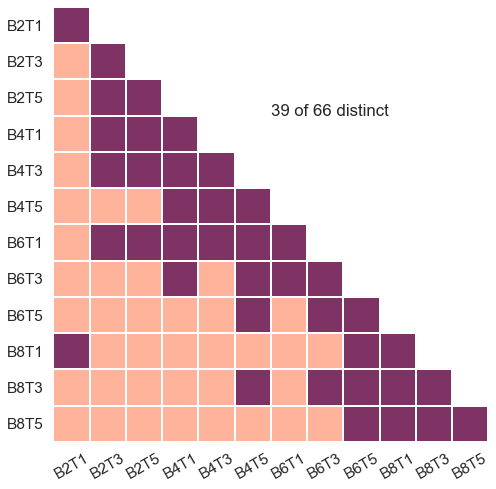

TFSI-flip


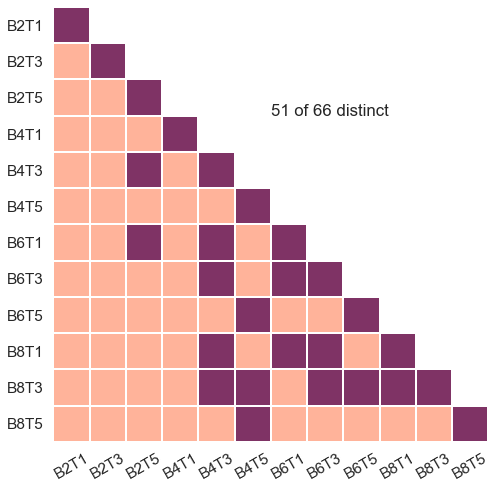

EC


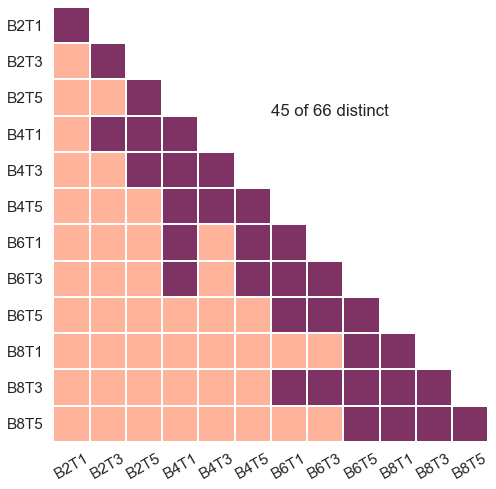

EC-flip


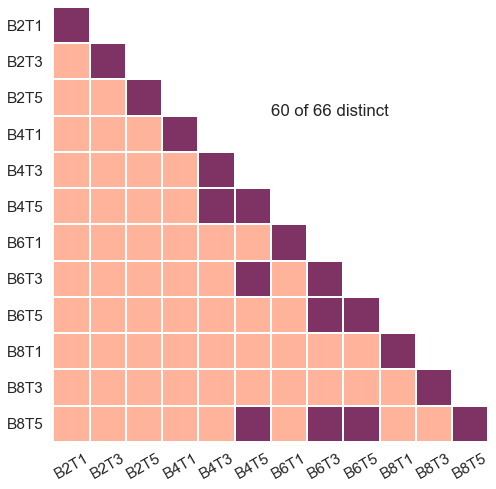

Li


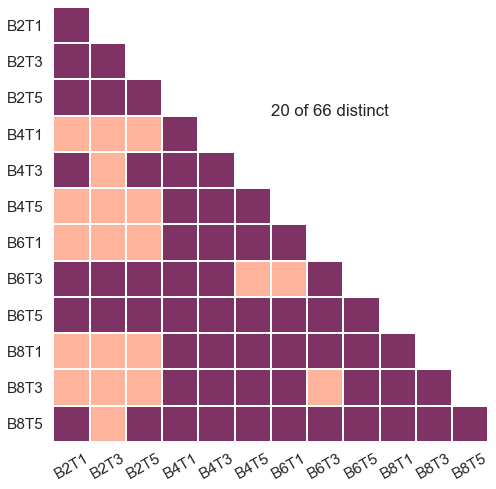

Li-flip


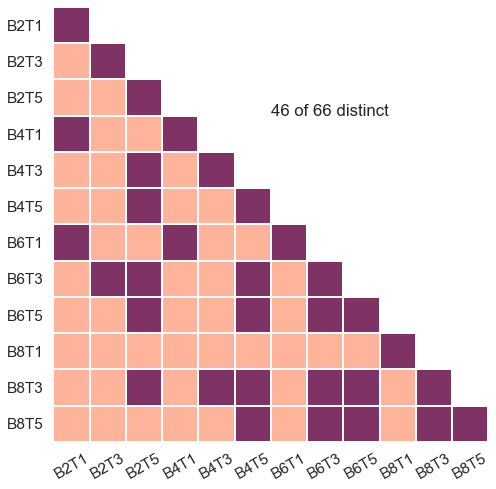

TFSI-2


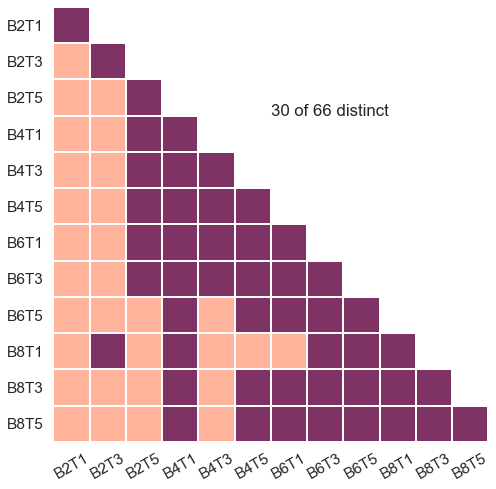

TFSI-2-flip


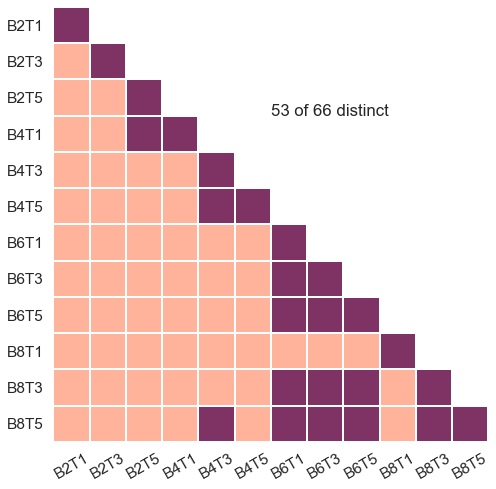

EC-2


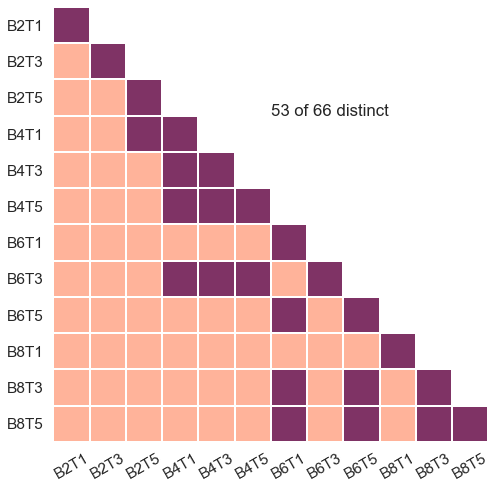

EC-2-flip


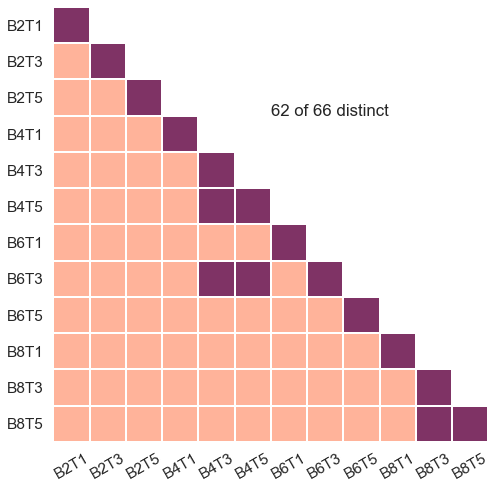

Li-2


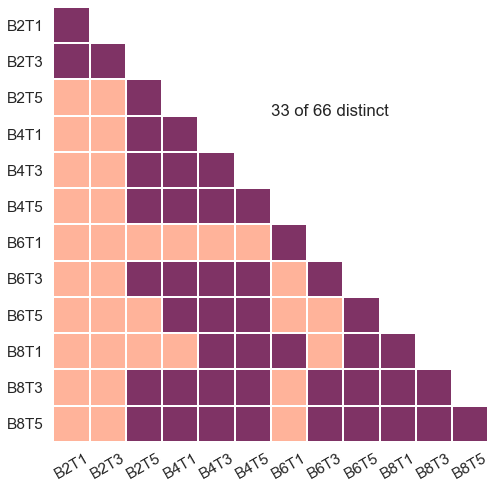

Li-2-flip


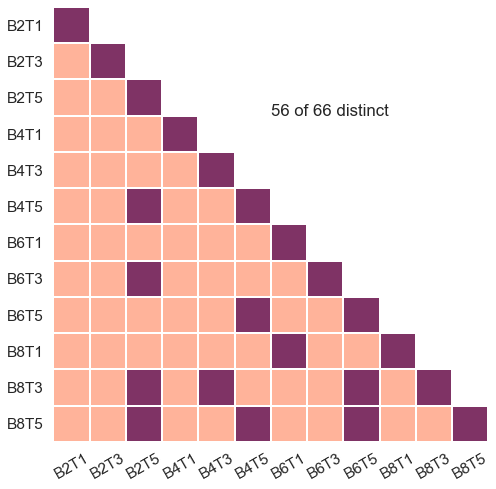

dr


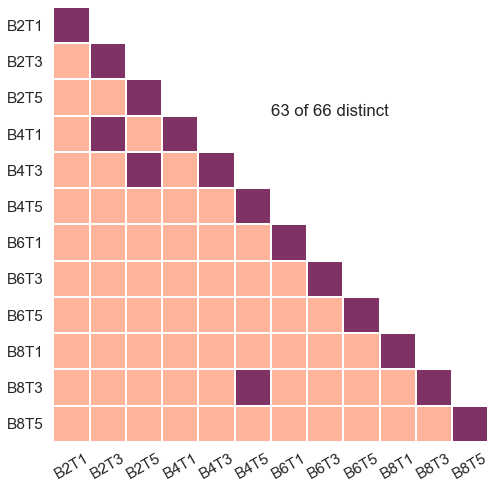

In [8]:
cols = df.system.unique()
rows = df.system.unique()

sns.set(font_scale=1.4, style="white")
for feat in columns:  # Loop through all features (and technically dr as well)
    print(feat)
    ad_matrix = np.zeros((12, 12))  # Initialize a 12 x 12 matrix
    # Nested for loop performs pairwise Anderson-Darling tests
    for i, col in enumerate(cols):
        for j, row in enumerate(rows):
            # 2-sample Anderson-Anderson Darling
            test = anderson_ksamp(
                [df[feat][df.system == col], df[feat][df.system == row]]
            )
            # Reject null hypothesis if statistic > critical value
            # True here means difference IS statistically significant
            ad_matrix[i, j] = test.statistic >= test.critical_values[5]

    # create a triangular mask for the hetamap
    mask = np.triu(np.ones_like(ad_matrix, dtype=bool))
    np.fill_diagonal(mask, False)

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        data=pd.DataFrame(ad_matrix, index=rows, columns=cols),
        vmin=0.15,  # vmin/vmax/center chosen for colors from cmap
        vmax=0.30,
        center=0.25,
        cmap=custom_cmap,
        linewidths=2,
        cbar=False,
        square=True,
        mask=mask,
    )
    # Count how many distinct distributions occur (add all True's)
    # Division by 2 needed since triangular mask created
    not_colored = int(ad_matrix.sum() / 2)
    plt.text(6, 3, f"{not_colored} of 66 distinct")
    plt.yticks(rotation=0)
    plt.xticks(rotation=30)
    plt.savefig(f"figures/anderson_{feat}.png", dpi=400, bbox_inches="tight")
    plt.show()

In general, distributions of dynamic features (flips) are more distinct across systems than the structural features (coordination number).

## UMAP Embeddings of Featurized Data

UMAP embeddings will be created to be able to visualize all the featurized data at once. Note that any separations between clusters in the UMAP embedding are due to differences within the *features*. This UMAP embedding is then colored by the "ground truths" (value or class for Li<sup>+</sup> displacement) to see whether the clusters are separated by displacement value. The embeddings clearly show that any differences in the featurized data don't have anything to do with differences in Li<sup>+</sup> displacement!

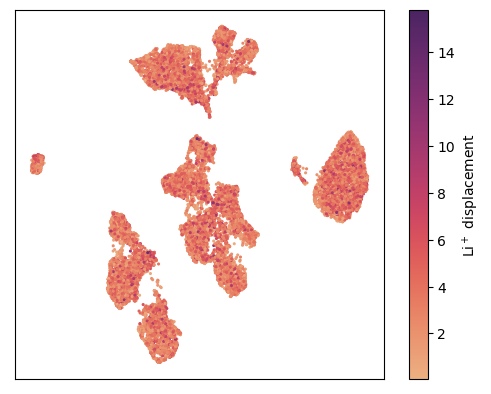

In [9]:
scaler = StandardScaler()
X = data.iloc[:, :-1]  # select all but dr, the target
X_scaled = scaler.fit_transform(X)
umap = UMAP(random_state=42)
embedding = umap.fit_transform(X_scaled)

plt.style.use("default")
emb_df = pd.DataFrame(
    {"UMAP_1": embedding[:, 0], "UMAP_2": embedding[:, 1], "dr": df["dr"]}
)
# norm and sm are here to create a colorbar for the scatterplot
norm = plt.Normalize(emb_df["dr"].min(), emb_df["dr"].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
# Create a scatterplkot of the UMAP embedding
ax = sns.scatterplot(
    data=emb_df,
    x="UMAP_1",
    y="UMAP_2",
    hue="dr",  # color based on the value of dr (not seen by UMAP!)
    legend="full",
    edgecolor="none",
    palette="flare",  # best palette on earth
    s=5,
)
# Remove axes since their meaning is not interpretable
ax.get_legend().remove()
ax.set_box_aspect(1)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.figure.colorbar(sm, label=r"Li$^+$ displacement")  # place colorbar
plt.savefig("figures/umap_reg.png", dpi=400, bbox_inches="tight")
plt.show()

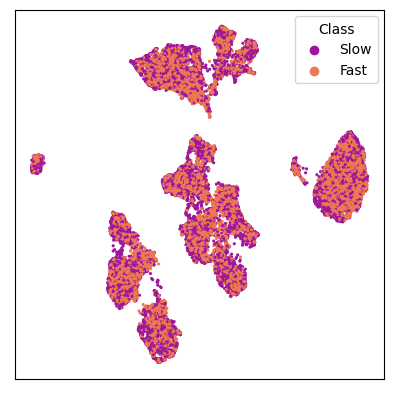

In [10]:
# plot the UMAP embedding, but now color by class (fast/slow) instead
emb_df = pd.DataFrame(
    {
        "UMAP_1": embedding[:, 0],
        "UMAP_2": embedding[:, 1],
        "Class": df["fast"].map({0.0: "Slow", 1.0: "Fast"}),
    }
)
ax = sns.scatterplot(
    data=emb_df,
    x="UMAP_1",
    y="UMAP_2",
    hue="Class",
    edgecolor="none",
    palette="plasma",
    s=5,
)
ax.set_box_aspect(1)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig("figures/umap_class.png", dpi=400, bbox_inches="tight")
plt.show()